In [46]:
from matplotlib import pyplot as plt

import xarray as xr
import netCDF4 as nc
import numpy as np

import os

import datetime as dt
import pickle

from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeCV, Ridge, LinearRegression, Lasso, ElasticNet
from sklearn.cross_decomposition import PLSRegression
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import r2_score
import random
from tqdm import tqdm
from collections import Counter
from AnchorOptimalProjector import *
import scipy
import h5py

In [47]:
models = ['CanESM5', 'MIROC-ES2L', 'MPI-ESM1-2-LR', 'MIROC6', 'CESM2']

In [48]:
import os
import h5py
import random
import numpy as np
import xarray as xr

def load_model_data(model, var, path='../data/', pkl=True):
    """
    Load model data from either a NetCDF (.nc) or a HDF5 (.h5) file.
    
    Args:
        model (str): Model name.
        var (str): Variable name.
        path (str, optional): Path to the data directory. Default is '../data/'.
        pkl (bool, optional): If True, loads data from a .h5 file; otherwise, from a .nc file. Default is True.
        
    Returns:
        numpy.ndarray: Array containing the loaded model data.
    """
    # Loading data file
    file_path = os.path.join(path, '{}_{}.nc'.format(model, var))
    ds = xr.open_dataset(file_path)
    # Getting variable data
    array = ds[var].values
    # Close the dataset
    ds.close()
    return array

def get_data_shape_lat_lon(model='CanESM5', var='pr', path='../data/'):
    """
    Get the shape and latitude/longitude coordinates of the data from a NetCDF file.
    
    Args:
        model (str, optional): Model name. Default is 'CanESM5'.
        var (str, optional): Variable name. Default is 'pr'.
        path (str, optional): Path to the data directory. Default is '../data/'.
        
    Returns:
        tuple: Shape of the data array, latitude coordinate, and longitude coordinate.
    """
    file_path = os.path.join(path, '{}_{}.nc'.format(model, var))
    ds = xr.open_dataset(file_path)
    # Getting variable data shape
    shape = ds[var].values.shape
    # Close the dataset
    ds.close()
    return shape, ds['lat'], ds['lon']

def load_data_models(models, var='pr', n_sample=10, path='../data/', coarse=12, window_size=10, pkl=False):
    """
    Load data from multiple models, preprocess it, and return the processed data for further analysis.
    
    Args:
        models (list): List of model names.
        var (str, optional): Variable name. Default is 'pr'.
        n_sample (int, optional): Number of samples to select randomly from each model's data. Default is 10.
        path (str, optional): Path to the data directory. Default is '../data/'.
        coarse (int, optional): Coarsening factor for spatial aggregation. Default is 12.
        window_size (int, optional): Size of the moving average window. Default is 10.
        pkl (bool, optional): If True, loads data from a .h5 file; otherwise, from a .nc file. Default is False.
        
    Returns:
        tuple: Arrays containing the regional internal variability, input data, and target data.
    """
    X, y, A = None, None, None
    for model in models:
        # Load model data
        array = load_model_data(model, var=var, path=path, pkl=pkl)
        
        shape = array.shape
        
        # Randomly select n_sample indices
        idxs = random.sample(range(shape[0]*shape[1]), n_sample)
        
        # Reshape data for spatial aggregation
        regional = array.reshape(shape[0], shape[1], shape[2]//coarse, coarse, shape[3]//coarse, coarse)
        
        # Spatially aggregate data
        X_temp = regional.mean(axis=(3, 5))
        rmt = X_temp.mean(axis=0)
        
        # Calculate regional internal variability
        riv = rmt - X_temp
        
        # Create a 1D convolution kernel for the moving average
        kernel = np.ones(window_size) / window_size
        
        # Smooth the regional internal variability using a moving average
        A_temp = np.apply_along_axis(lambda x: np.convolve(x, kernel, mode='same'), axis=1, arr=riv)
        
        # Reshape data for further processing
        X_temp = X_temp.reshape(shape[0]*shape[1], shape[2]*shape[3]//(coarse**2))
        y_temp = np.tile(array.mean(axis=0), (shape[0], 1, 1)).reshape(shape[0]*shape[1], shape[2]*shape[3])
        A_temp = A_temp.reshape(shape[0]*shape[1], shape[2]*shape[3]//(coarse**2))

        # Concatenate data from current model with existing data
        if X is None:
            X = X_temp[idxs,:]
            y = y_temp[idxs,:]
            A = A_temp[idxs, :] 
        else:
            X = np.vstack((X, X_temp[idxs,:]))
            y = np.vstack((y, y_temp[idxs,:]))
            A = np.vstack((A, A_temp[idxs,:]))
        
        # Cleanup temporary variables to free memory
        del array
        del X_temp
        del y_temp
        del A_temp
        
    return A, X, y


In [49]:
shape, lat, lon = get_data_shape_lat_lon()
d = shape[2]*shape[3]

# Training

* We train the anchor OPLS model :
  * Train/Test splits are randomly sampled accross models (training on 4 model and testing on the 5th)
  * Optimal hyperparameters are estimated by Train-validation split for each random split and are then averaged

In [50]:
# Randomly sampling across models to create Train/Test splits
# B = 50
# models_test = random.choices(models, k=B)
models_test = models
models_train = [[model for model in models if model != model_test ] for model_test in models_test ]

In [51]:
# Counting occurence of each test model
occurence_models_test = Counter(models_test)
occurence_models_test

Counter({'CanESM5': 1,
         'MIROC-ES2L': 1,
         'MPI-ESM1-2-LR': 1,
         'MIROC6': 1,
         'CESM2': 1})

In [52]:
# Trianing parameters
var = 'pr' # Selecting the training variable: {tas, pr, psl}

N = 3000
n_components = np.arange(1, 300, 5)
regularisations = [1e2, 1e3]
coarse = 4
gammas = [1, 2, 5]

In [53]:
# Loading or creating weights
try :
    directory = '../weights/'
    file = 'Anchor_OPLS_{var}_weights_stability_n{}_coarse{}.pkl'.format(N, coarse)
    with open(directory + file, 'rb') as f:
        weights = pickle.load(f)
except:
    print('Weights does not exists!')
    weights = {model:{gamma : {'weights':None, 'n_samples': N*occurence_models_test[model]} for gamma in gammas} for model in models}
    
for model in models : 
    for gamma in gammas :
        if gamma not in weights[model].keys():
            weights[model][gamma]['weights'] = None
            weights[model][gamma]['n_samples'] = N*occurence_models_test[model]

Weights does not exists!


In [54]:
# Loop through each model in the test set
for i in tqdm(range(len(models_test))):
    m_train, m_test = models_train[i], models_test[i]
    
    # Load and preprocess data
    A_train, X_train, Y_train = load_data_models(m_train, var=var, n_sample=N, coarse=coarse)
    AOP = AnchorOptimalProjection(gamma=gammas)
    X_trains, Y_trains = AOP.fit_transform(A_train, X_train, Y_train)
    del A_train, X_train, Y_train
    
    # Loop through each gamma value
    for gamma in gammas:
        score, ncp_opt, reg_opt = -np.Inf, None, None
        
        # Split data into training and validation sets
        X_train, X_val, Y_train, Y_val = train_test_split(X_trains[gamma], Y_trains[gamma])
        C_XY = X_train.T @ Y_train 
        C_XX = X_train.T @ X_train
        del X_train, Y_train
        
        # Regularization
        for reg in regularisations:
            C_XX_inv = np.linalg.inv(C_XX + reg * np.identity(C_XX.shape[0]))
            C = C_XY.T @ C_XX_inv @ C_XY
            u, v = scipy.sparse.linalg.eigs(C, k=np.max(n_components))
            u, v = u.real, v.real
            idx = np.argsort(u)[::-1]
            eig = u[idx]
            V = v[:, idx]
            U = C_XX_inv @ C_XY @ V
                
            # Try different numbers of components
            for n_cp in n_components[::-1]:
                Y_pred = X_val @ U[:,:n_cp] @ V.T[:n_cp, :]
                score_temp = r2_score(Y_val, Y_pred)
                
                # Update if the score is better
                if score_temp > score:
                    score = score_temp
                    ncp_opt = n_cp
                    reg_opt = reg
            del C_XX_inv, C
        del X_val, Y_val, C_XY, C_XX
        print(score, ncp_opt, reg_opt, gamma)
        
        # Save the weights
        if weights[m_test][gamma]['weights'] is None:
            weights[m_test][gamma]['weights'] = U[:,:ncp_opt] @ V.T[:ncp_opt, :]
        else:
            weights[m_test][gamma]['weights'] = (weights[m_test][gamma]['n_samples'] * weights[m_test][gamma]['weights'] + N * occurence_models_test[m_test] * U[:,:ncp_opt] @ V.T[:ncp_opt, :]) / (N * occurence_models_test[m_test] + weights[m_test][gamma]['n_samples'])
            weights[m_test][gamma]['n_samples'] += N * occurence_models_test[m_test]

# Save the weights to a file
file_path = f'../weights/Anchor_OPLS_{var}_weights_stability_n{N}_coarse{coarse}.pkl'
with open(file_path, 'wb') as f:
    pickle.dump(weights, f)


  0%|          | 0/5 [00:00<?, ?it/s]

0.028564680753321487 121 1000.0 1


# Testing 

In [ ]:
# Loading weights
file_path = f'../weights/Anchor_OPLS_{var}_weights_stability_n{N}_coarse{coarse}.pkl'
with open(file_path, 'rb') as f:
    weights = pickle.load(f)

For each model, we load the weights for which training as not been done on it and evaluate the performance by randomly sampling testing data from this model

In [ ]:
R = 6

# Initialize scores_pattern dictionary
scores_pattern = {model: {gamma: [] for gamma in weights[model].keys()} for model in models}

# Iterate R times
for b in tqdm(range(R)):
    # Iterate through each model
    for model in models:
        # Iterate through each gamma value for the current model
        for gamma in weights[model].keys():
            # Load test data
            _, X_test, Y_test = load_data_models([model], var=var, coarse=coarse, n_sample=1000)
            
            # Load weights
            W = weights[model][gamma]['weights']
            
            # Predict using loaded weights
            Y_pred = X_test @ W
            
            # Compute scores
            score_pattern = r2_score(Y_test, Y_pred, multioutput='raw_values')
            scores_pattern[model][gamma].append(score_pattern)
            
            # Clean up variables to free memory
            del X_test
            del Y_pred
            del Y_test


  0%|          | 0/6 [00:00<?, ?it/s]

100%|██████████| 6/6 [10:22<00:00, 103.72s/it]


In [ ]:
gamma=1

In [ ]:
np.array([np.mean(scores_pattern['MIROC6'][gamma], axis=1) for model in models]).mean()

0.3453343508202691

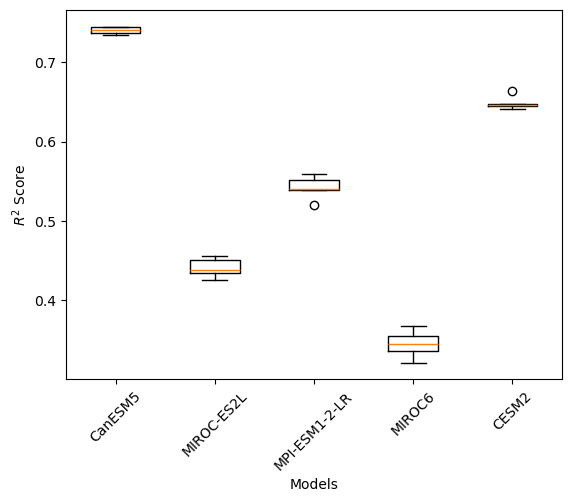

In [ ]:
# Create a boxplot of mean R2 scores for each model
plt.boxplot([np.mean(scores_pattern[model][gamma], axis=1) for model in models])

# Set xticklabels with model names
plt.xticks(range(1, len(models) + 1), [model for model in models], rotation=45)

# Set xlabel with models
plt.xlabel(r'Models')

# Set ylabel with R2 score
plt.ylabel(r'$R^2$ Score')

# Define directory for saving the plot
directory = '../results'

# Save the plot as a PDF file with specified gamma and coarse values in the filename
plt.savefig(directory + "/R2_pr_anchor_OPLS{}_stability_coarse{}_precip.pdf".format(gamma, coarse), format="pdf", bbox_inches="tight")

# Show the plot
plt.show()


In [ ]:
model = 'MIROC6'
scores_pattern_maps = np.mean(scores_pattern[model][gamma], axis=0).reshape(len(lat), len(lon))

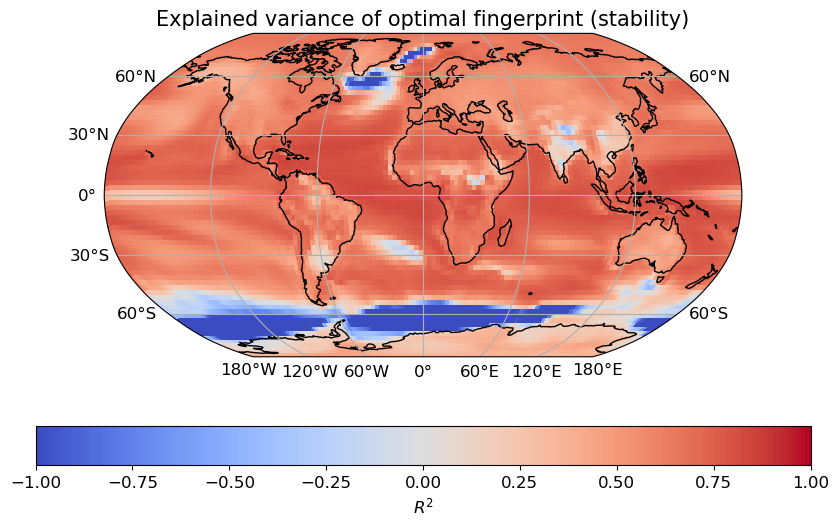

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from matplotlib.colors import TwoSlopeNorm

# Assuming you have defined lat, lon, scores_pattern_maps, gamma, coarse, model

# Plotting
fig = plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.Robinson())

# Set normalization for color scale
norm_r2 = TwoSlopeNorm(vmin=-1, vcenter=0.0, vmax=1)

# Plot pcolormesh for scores_pattern_maps
contour_r2 = ax.pcolormesh(lon, lat, scores_pattern_maps, transform=ccrs.PlateCarree(), cmap='coolwarm', norm=norm_r2)

# Add coastlines
ax.coastlines()

# Add gridlines with labels
gl = ax.gridlines(draw_labels=True)
gl.top_labels = gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 12}  # Longitude font size
gl.ylabel_style = {'size': 12}  # Latitude font size

# Set title
ax.set_title(r'Explained variance of optimal fingerprint (stability)', fontsize=15)

# Add colorbar
cb = plt.colorbar(contour_r2, ax=ax, label='R2 score differences', orientation='horizontal')
cb.ax.tick_params(labelsize=12)
cb.set_label(r'$R^2$', fontsize=12) 

# Save the plot as a PDF file with specified gamma, coarse, and model values in the filename
plt.savefig(directory + "/maps_R2_anchor{}_stability_coarse_{}_{}_precip.pdf".format(gamma, coarse, model), format="pdf", bbox_inches="tight")

# Show the plot
plt.show()
